In [45]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight

import lightgbm as lgb

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [46]:
test.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Insulin_na,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,0,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
mean,2509,3.584,114.3,68.77,11.2,11.86,35.59,0.4018,29.08,NaN,...,0.919,0.0365,0.1203,26.71,71.37,136.5,0.1195,0.355,0.273,0.2525
std,1438,3.054,21.99,16.17,14.06,49.83,6.937,0.2671,8.572,NaN,...,0.2729,0.1876,0.09919,5.128,9.077,29.91,0.3245,0.4786,0.4456,0.4346
min,1,0,57,0,0,0,9.286,0.1374,21,NaN,...,0,0,0,8,38,15,0,0,0,0
25%,1285,1,100,64,0,0,32.58,0.2346,22,NaN,...,1,0,0.04545,26.88,64,135.6,0,0,0,0
50%,2550,3,111,70,0,0,33.81,0.2713,26,NaN,...,1,0,0.09717,26.88,71.41,135.6,0,0,0,0
75%,3744,6,125,78,24.25,0,39.69,0.5064,33,NaN,...,1,0,0.1717,26.88,78,135.6,0,1,1,1
max,4995,13,199,110,52,744,52.96,2.176,67,NaN,...,1,1,0.5909,52,110,744,1,1,1,1


In [47]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Insulin_na,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
count,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,...,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000
mean,2493,3.557,113.7,68.74,11.16,11.66,35.41,0.4005,28.93,0.239,...,0.9147,0.03767,0.1201,26.98,71.43,135.7,0.1433,0.3307,0.272,0.254
std,1447,3.032,20.89,16.33,14.35,45.06,6.99,0.2747,8.469,0.4265,...,0.2794,0.1904,0.1003,5.248,9.04,23.92,0.3505,0.4705,0.4451,0.4354
min,0,0,57,0,0,0,7.748,0.1458,21,0,...,0,0,0,7,46,15,0,0,0,0
25%,1219,1,100,64,0,0,32.3,0.231,22,0,...,1,0,0.04545,26.88,64,135.6,0,0,0,0
50%,2466,3,111,70,0,0,33.84,0.2687,26,0,...,1,0,0.09878,26.88,71.41,135.6,0,0,0,0
75%,3750,6,125,78,24,0,39.58,0.5068,33,0,...,1,0,0.1724,26.88,78,135.6,0,1,1,1
max,4999,13,196,110,49,579,53.4,2.302,67,1,...,1,1,0.619,49,110,579,1,1,1,1


In [48]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'SkinThickness',
                 'Insulin',
                 'BloodPressure',
                 
                 
                 
                
             ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [49]:
# 数値データ
col_num = X_train.columns[X_train.dtypes!='object'].values.tolist()

dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    X_train[col] = X_train[col].fillna(value_fillna)
    # 正規化
    value_min = X_train[col].min()
    value_max = X_train[col].max()
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    #X_train[col] = (X_train[col] - value_min) / (value_max -value_min)
    X_train[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_mean    
    dict_num[col]['std'] = value_std  
    
print('Done')

DiabetesPedigreeFunction
BMI
Glucose
Age
Pregnancies
SkinThickness
Insulin
BloodPressure
Done


In [50]:
# カテゴリデータ
# （embedding予定でラベルエンコーダー）
col_cat = X_train.columns[X_train.dtypes=='object'].values.tolist()

dict_cat = {}
for col in col_cat:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[cal].fillna(value_fillna)
    
    X_train[caol] = X_train[col].astype(str)
    # strに変換
    le = LabelEncorder()
    le.fit(X_train[col])
    list_labelsorted(list(set(le.classes_) | set(['unknown'])))
    map_label = {j:i for i,j in enumerate(list_label)}
    X_train[col] = X_train[col].map(map_label)
    
    dict_cat[col] = {}
    dict_cat[col]['fillna'] = value_fillna
    dict_cat[col]['map_label'] = map_label
    dict_cat[col]['num_label'] = len(list_label)

print('Done')


Done


In [51]:
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        value_mean = dict_num[col]['mean']
        value_std = dict_num[col]['std']
        
        output_x[col]  = (output_x[col] - value_mean ) / (value_std)
        
    for col in col_cat:
        value_fillna = dict_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_catt[col]['map_label']
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    return output_x

X_test = transform_data(X_test)

In [52]:
pd.options.display.float_format = '{:.4g}'.format
X_train.describe()

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,SkinThickness,Insulin,BloodPressure
count,3000,3000,3000,3000,3000,3000,3000,3000
mean,1.599e-16,-5.797e-16,1.007e-16,1.563e-16,4.619e-17,1.451e-17,4.441e-17,-1.918e-16
std,1,1,1,1,1,1,1,1
min,-0.9271,-3.957,-2.716,-0.9366,-1.173,-0.7779,-0.2588,-4.209
25%,-0.6171,-0.4445,-0.6576,-0.8185,-0.8433,-0.7779,-0.2588,-0.2904
50%,-0.4799,-0.225,-0.1309,-0.3462,-0.1837,-0.7779,-0.2588,0.07692
75%,0.387,0.5965,0.5394,0.4803,0.8057,0.8944,-0.2588,0.5667
max,6.923,2.574,3.939,4.495,3.114,2.636,12.59,2.526


In [53]:
X_test.describe()

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,SkinThickness,Insulin,BloodPressure
count,2000,2000,2000,2000,2000,2000,2000,2000
mean,0.004658,0.02542,0.0268,0.01694,0.008905,0.002787,0.004342,0.001398
std,0.9723,0.9924,1.053,1.012,1.007,0.9794,1.106,0.9903
min,-0.9579,-3.737,-2.716,-0.9366,-1.173,-0.7779,-0.2588,-4.209
25%,-0.6038,-0.4045,-0.6576,-0.8185,-0.8433,-0.7779,-0.2588,-0.2904
50%,-0.4704,-0.2281,-0.1309,-0.3462,-0.1837,-0.7779,-0.2588,0.07692
75%,0.3858,0.6131,0.5394,0.4803,0.8057,0.9118,-0.2588,0.5667
max,6.464,2.511,4.083,4.495,3.114,2.845,16.25,2.526


In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD

random_state=123

In [55]:
def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

## validation方法 NN

In [81]:
def create_model():
    input_num = Input(shape=(8,))
    x_num = Dense(10, activation='relu')(input_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.3)(x_num)
    x_num = Dense(10, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.2)(x_num)
    x_num = Dense(5, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.1)(x_num)
    out = Dense(1, activation='sigmoid')(x_num)
    
    model = Model(inputs=input_num, outputs=out,)
    
    model.compile(
        optimizer='Adam',
        loss='binary_crossentropy',
        metrics=['binary_crossentropy'],
    )
    
    return model

In [82]:
# モデルの確認
model = create_model()
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_28 (Dense)            (None, 10)                90        
                                                                 
 batch_normalization_21 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 10)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
 batch_normalization_22 (Bat  (None, 10)               40        
 chNormalization)                                          

In [83]:
#不均衡データ用の重み
class_weights = list(class_weight.compute_class_weight('balanced', 
                                                           classes=np.unique(y_train['Outcome']),
                                                           y=y_train['Outcome'])
                        )
class_weights.reverse()
# fit時にclass_weightに辞書でに有力
weight_dict = dict(zip(y_train['Outcome'], class_weights))
print(weight_dict)

{1.0: 2.092050209205021, 0.0: 0.657030223390276}


In [84]:
# cvでの評価用
def train_nn(input_x,
              input_y,
              input_id,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
                         
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = create_model()
        model.fit(x=x_tr,
                  y=y_tr,
                 validation_data=(x_va, y_va),
                 batch_size=8,
                 epochs=1000,
                 class_weight=None,
                 callbacks=[ModelCheckpoint(filepath='model_keras.h5',
                                            moniter='val_loss',
                                            mode='min', 
                                            verbose=1,
                                            save_best_only=True,
                                            ),
                            EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          min_delta=0,
                                          patience=5,
                                          verbose=1,
                                          restore_best_weights=True),
                            ReduceLROnPlateau(moniter='val_loss',
                                             mode='min',
                                             factor=0.1,
                                             patience=5,
                                             verbose=1),
                           ],
                  verbose=1,
                 )

        # モデルの保存
        fname_nn = 'model/nn/model_nn_fold{}.pickle'.format(nfold)
        with open(fname_nn, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
            
        # 評価
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = np.squeeze(y_va_pred)
        
        
        print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)

    print('Done')
    
    return train_oof, metrics

In [85]:
train_oof, metrics = train_nn(X_train, y_train, id_train, list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

-------------------- 0 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
Epoch 1/1000
292/300 [============================>.] - ETA: 0s - loss: 0.6518 - binary_crossentropy: 0.6518
Epoch 1: val_loss improved from inf to 0.54800, saving model to model_keras.h5
300/300 [==============================] - 2s 4ms/step - loss: 0.6505 - binary_crossentropy: 0.6505 - val_loss: 0.5480 - val_binary_crossentropy: 0.5480 - lr: 0.0010
Epoch 2/1000
296/300 [============================>.] - ETA: 0s - loss: 0.5651 - binary_crossentropy: 0.5651
Epoch 2: val_loss improved from 0.54800 to 0.51699, saving model to model_keras.h5
300/300 [==============================] - 1s 3ms/step - loss: 0.5645 - binary_crossentropy: 0.5645 - val_loss: 0.5170 - val_binary_crossentropy: 0.5170 - lr: 0.0010
Epoch 3/1000
292/300 [============================>.] - ETA: 0s - loss: 0.5432 - binary_crossentropy: 0.5432
Epoch 3: val_loss improved from 0.51699 to 0.50391, saving m

In [87]:
train_oof[:3]

,index,pred
0,200,0.3985
1,3832,0.1144
2,4927,0.4139


## 推論

In [88]:
def predict_nn(input_x,
               input_id,
               list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_nn = 'model/nn/model_nn_fold{}.pickle'.format(nfold)
        with open(fname_nn, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = np.squeeze(model.predict(input_x))
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [89]:
test_pred_proba = predict_nn(X_test,
                    id_test,
                    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
63/63 [==============================] - 0s 2ms/step
-------------------- 1 --------------------
63/63 [==============================] - 0s 2ms/step
-------------------- 2 --------------------
63/63 [==============================] - 0s 2ms/step
-------------------- 3 --------------------
63/63 [==============================] - 0s 2ms/step
-------------------- 4 --------------------
63/63 [==============================] - 0s 2ms/step
Done


In [90]:
test_pred_proba[:3]

,index,pred
0,398,0.2608
1,3833,0.1209
2,4836,0.1148


In [91]:
test_pred = test_pred_proba.copy()  
test_pred['pred']=np.where(test_pred['pred'] < 0.5, 0, 1)
test_pred[:3]

,index,pred
0,398,0
1,3833,0
2,4836,0


In [92]:
train_oof[:3]

,index,pred
0,200,0.3985
1,3832,0.1144
2,4927,0.4139


In [93]:
test_pred.to_csv('sub/submission_nn_weight.csv', index=None, header=False,)

## アンサンブル用データ

In [94]:
import pickle
 
with open('ensamble/nnw_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/nnw_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン検証

In [72]:
random_state=123

x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (2400, 8) (2400, 1)
ベースライン検証データ:  (600, 8) (600, 1)
検証データ(train):  (1920, 8) (1920, 1)
検証データ(test):  (480, 8) (480, 1)


In [73]:
from modules import Add_class_wight
class_weights = Add_class_wight(y_tr['Outcome'])
class_weights

array([2.09 , 2.09 , 0.657, ..., 0.657, 2.09 , 0.657], dtype=float16)

In [74]:
#validation結果
model = create_model()
model.fit(
    x=x_tr,
    y=y_tr,
    validation_data=(x_va1, y_va1),
    batch_size=8,
    epochs=1000,
    class_weight=weight_dict,
    callbacks=[ModelCheckpoint(filepath='model_keras.h5',
                            moniter='val_loss',
                            mode='min', 
                            verbose=1,
                            save_best_only=True,
                            ),
            EarlyStopping(monitor='val_loss',
                          mode='min',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True),
            ReduceLROnPlateau(moniter='val_loss',
                             mode='min',
                             factor=0.1,
                             patience=5,
                             verbose=1),
           ],
    verbose=1,

         )

Epoch 1/1000
288/300 [===========================>..] - ETA: 0s - loss: 0.7275 - binary_crossentropy: 0.7274
Epoch 1: val_loss improved from inf to 0.74773, saving model to model_keras.h5
300/300 [==============================] - 2s 4ms/step - loss: 0.7277 - binary_crossentropy: 0.7273 - val_loss: 0.7477 - val_binary_crossentropy: 0.7477 - lr: 0.0010
Epoch 2/1000
282/300 [===========================>..] - ETA: 0s - loss: 0.6852 - binary_crossentropy: 0.6915
Epoch 2: val_loss improved from 0.74773 to 0.70938, saving model to model_keras.h5
300/300 [==============================] - 1s 4ms/step - loss: 0.6861 - binary_crossentropy: 0.6896 - val_loss: 0.7094 - val_binary_crossentropy: 0.7094 - lr: 0.0010
Epoch 3/1000
297/300 [============================>.] - ETA: 0s - loss: 0.6730 - binary_crossentropy: 0.6779
Epoch 3: val_loss improved from 0.70938 to 0.69369, saving model to model_keras.h5
300/300 [==============================] - 1s 3ms/step - loss: 0.6741 - binary_crossentropy: 0.6

In [79]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, np.where(y_va1_pred>=0.5,1,0))))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, np.where(y_va2_pred>=0.5,1,0))))


print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred)))


19/19 [==============================] - 0s 2ms/step
[検証データ] acc: 0.6667
[ベースライン検証データ] acc: 0.7133
[検証データ] auc: 0.7352
[ベースライン検証データ] auc: 0.7854


In [80]:
#誤分類の分布
print('検証データ')
print(confusion_matrix(y_va1, np.where(y_va1_pred>=0.5,1,0)))
print(confusion_matrix(y_va1, np.where(y_va1_pred>=0.5,1,0), normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, np.where(y_va2_pred>=0.5,1,0)))
print(confusion_matrix(y_va2, np.where(y_va2_pred>=0.5,1,0), normalize='all'))

検証データ
[[237 128]
 [ 32  83]]
[[0.49375    0.26666667]
 [0.06666667 0.17291667]]
ベースライン検証データ
[[321 136]
 [ 36 107]]
[[0.535      0.22666667]
 [0.06       0.17833333]]


19/19 [==============================] - 0s 2ms/step


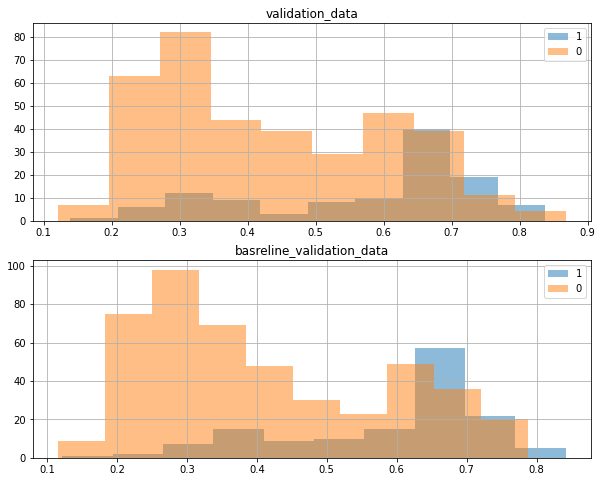

In [78]:
# 予測値の分布
y_va1_pred_prob = model.predict(x_va1)
y_va2_pred_prob = model.predict(x_va2)

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

## チューニング

In [ ]:
import optuna

In [76]:
# 探索しないパラメータ

params_base = {
   'optimizer_fn': torch.optim.Adam,
   'optimizer_params': {'lr':2e-2,'weight_decay':1e-5},
   'mask_type': "entmax",#AttentiveTransformerでマスク作るのにどっちの関数を使うか'sparsemax'or'entmax'
   'scheduler_params':{'mode': "min",'patience': 5,'min_lr': 1e-5,'factor': 0.9, 'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,},
   'verbose':10,
   'seed': 123,
}

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'n_d': trial.suggest_int('n_d',8,64),
        'n_a': trial.suggest_int('n_a',8,64),
        'n_steps': trial.suggest_int('n_steps', 1, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'mask_type': trial.suggest_categorical('mask_type', ['entmatx','sparsemax']),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(X_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
       
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [80]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-19 14:25:48,430] A new study created in memory with name: no-name-c35efe1d-ef61-45ef-ad8a-57bab052cf43


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:01s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:26:41,692] Trial 0 finished with value: 0.7656666666666667 and parameters: {'n_d': 47, 'n_a': 24, 'n_step': 3, 'gamma': 1.5513147690828912, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:27:34,868] Trial 1 finished with value: 0.7656666666666667 and parameters: {'n_d': 63, 'n_a': 47, 'n_step': 5, 'gamma': 1.3921175181941505, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:28:29,472] Trial 2 finished with value: 0.7656666666666667 and parameters: {'n_d': 32, 'n_a': 11, 'n_step': 4, 'gamma': 1.7379954057320357, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:29:23,197] Trial 3 finished with value: 0.7656666666666667 and parameters: {'n_d': 38, 'n_a': 38, 'n_step': 7, 'gamma': 1.8494317940777896, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:30:20,692] Trial 4 finished with value: 0.7656666666666667 and parameters: {'n_d': 49, 'n_a': 26, 'n_step': 4, 'gamma': 1.2282632308789556, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:31:14,682] Trial 5 finished with value: 0.7656666666666667 and parameters: {'n_d': 13, 'n_a': 32, 'n_step': 5, 'gamma': 1.4936850976503062, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:32:10,297] Trial 6 finished with value: 0.7656666666666667 and parameters: {'n_d': 32, 'n_a': 58, 'n_step': 10, 'gamma': 1.5018366758843364, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:01s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:33:05,604] Trial 7 finished with value: 0.7656666666666667 and parameters: {'n_d': 26, 'n_a': 31, 'n_step': 9, 'gamma': 1.2504553653965067, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:34:03,700] Trial 8 finished with value: 0.7656666666666667 and parameters: {'n_d': 37, 'n_a': 42, 'n_step': 2, 'gamma': 1.8263408005068333, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:05s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:35:00,323] Trial 9 finished with value: 0.7656666666666667 and parameters: {'n_d': 27, 'n_a': 25, 'n_step': 5, 'gamma': 1.6813007657927965, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:35:54,823] Trial 10 finished with value: 0.7656666666666667 and parameters: {'n_d': 56, 'n_a': 8, 'n_step': 1, 'gamma': 1.0080611434040203, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:36:49,120] Trial 11 finished with value: 0.7656666666666667 and parameters: {'n_d': 63, 'n_a': 51, 'n_step': 3, 'gamma': 1.9862890564016848, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:37:44,848] Trial 12 finished with value: 0.7656666666666667 and parameters: {'n_d': 48, 'n_a': 46, 'n_step': 7, 'gamma': 1.555399472872045, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:05s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:38:40,678] Trial 13 finished with value: 0.7656666666666667 and parameters: {'n_d': 64, 'n_a': 19, 'n_step': 7, 'gamma': 1.3631357691972947, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:39:35,045] Trial 14 finished with value: 0.7656666666666667 and parameters: {'n_d': 49, 'n_a': 59, 'n_step': 3, 'gamma': 1.6071903264160659, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:40:30,787] Trial 15 finished with value: 0.7656666666666667 and parameters: {'n_d': 56, 'n_a': 19, 'n_step': 1, 'gamma': 1.4511497032783554, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:41:27,051] Trial 16 finished with value: 0.7656666666666667 and parameters: {'n_d': 44, 'n_a': 49, 'n_step': 6, 'gamma': 1.3844748717398336, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:42:21,674] Trial 17 finished with value: 0.7656666666666667 and parameters: {'n_d': 57, 'n_a': 38, 'n_step': 3, 'gamma': 1.6228321701158495, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:05s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:43:17,846] Trial 18 finished with value: 0.7656666666666667 and parameters: {'n_d': 13, 'n_a': 54, 'n_step': 6, 'gamma': 1.3222958430513911, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:44:12,759] Trial 19 finished with value: 0.7656666666666667 and parameters: {'n_d': 43, 'n_a': 62, 'n_step': 8, 'gamma': 1.5520330411371615, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:45:08,441] Trial 20 finished with value: 0.7656666666666667 and parameters: {'n_d': 59, 'n_a': 15, 'n_step': 4, 'gamma': 1.4356061202518677, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:46:05,297] Trial 21 finished with value: 0.7656666666666667 and parameters: {'n_d': 21, 'n_a': 8, 'n_step': 4, 'gamma': 1.7069340307634664, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:01s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:46:59,923] Trial 22 finished with value: 0.7656666666666667 and parameters: {'n_d': 29, 'n_a': 14, 'n_step': 2, 'gamma': 1.7163415570713012, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:47:54,900] Trial 23 finished with value: 0.7656666666666667 and parameters: {'n_d': 20, 'n_a': 25, 'n_step': 5, 'gamma': 1.6119687787895545, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:48:50,379] Trial 24 finished with value: 0.7656666666666667 and parameters: {'n_d': 41, 'n_a': 31, 'n_step': 4, 'gamma': 1.7913032879236999, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:49:47,427] Trial 25 finished with value: 0.7656666666666667 and parameters: {'n_d': 33, 'n_a': 14, 'n_step': 2, 'gamma': 1.494434901957632, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:02s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:04s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:06s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:07s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:09s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:10s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:50:44,496] Trial 26 finished with value: 0.7656666666666667 and parameters: {'n_d': 52, 'n_a': 19, 'n_step': 3, 'gamma': 1.7716585404282987, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:51:39,812] Trial 27 finished with value: 0.7656666666666667 and parameters: {'n_d': 22, 'n_a': 42, 'n_step': 6, 'gamma': 1.6495702502566643, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:10s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:52:36,215] Trial 28 finished with value: 0.7656666666666667 and parameters: {'n_d': 53, 'n_a': 44, 'n_step': 5, 'gamma': 1.570458959494639, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:53:31,376] Trial 29 finished with value: 0.7656666666666667 and parameters: {'n_d': 39, 'n_a': 23, 'n_step': 4, 'gamma': 1.864792365897348, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009


In [81]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.7657


{'n_d': 47,
 'n_a': 24,
 'n_step': 3,
 'gamma': 1.5513147690828912,
 'mask_type': 'entmatx'}

In [82]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'n_d': 47,
 'n_a': 24,
 'n_step': 3,
 'gamma': 1.5513147690828912,
 'mask_type': 'entmax',
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02, 'weight_decay': 1e-05},
 'scheduler_params': {'mode': 'min',
  'patience': 5,
  'min_lr': 1e-05,
  'factor': 0.9,
  'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau},
 'verbose': 10,
 'seed': 123}